In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit import Aer, execute
from qiskit.providers.aer import StatevectorSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
from math import pi, sqrt
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT

# Experiment with X+T gate. Ideally it should still bring a phase change of theta = 1/8

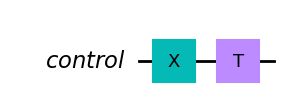

In [17]:
a = QuantumRegister(1, 'control')
qc = QuantumCircuit(a)
qc.x(a)
qc.t(a)
uGate = qc.to_gate().control()
qc.draw(output='mpl')

# The eigen vector for X + T gate is
# [0.9759
# 0.2182]
# Thus applying value to initialise the gate.

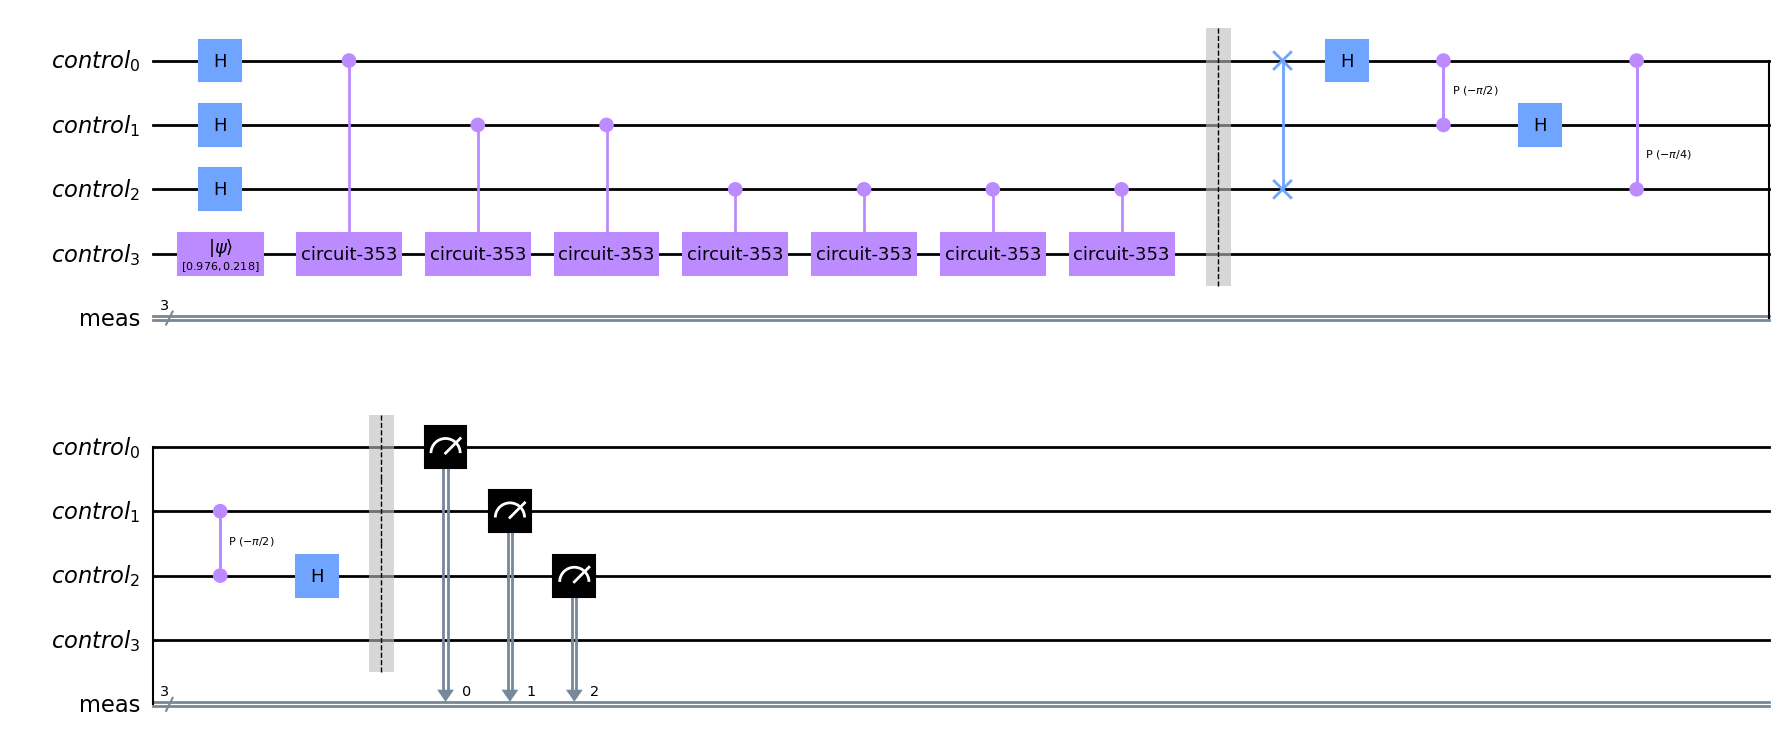

In [18]:
nqubits = 3 #precision qubit
b = QuantumRegister(nqubits+1, 'control')
c = ClassicalRegister(nqubits, 'meas')
qpe = QuantumCircuit(b, c)
for qubit in range(nqubits):
    qpe.h(qubit)
#qpe.x(b[nqubits])
qpe.initialize([0.9759, sqrt(1-(0.9759*0.9759))], nqubits)
#qpe.h(b[nqubits])
repetitions = 1
for counting_qubit in range(nqubits):
    for i in range(repetitions):
        qpe.append(uGate, [counting_qubit] + [nqubits]); # This is CU
    repetitions *= 2
    
    
    
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-pi/float(2**(j-m)), m, j)
        qc.h(j)
        
        
qpe.barrier()
qft_dagger(qpe, nqubits)
# Measure
qpe.barrier()
for i in range(nqubits):
    qpe.measure(i,i)
qpe.draw(output='mpl')

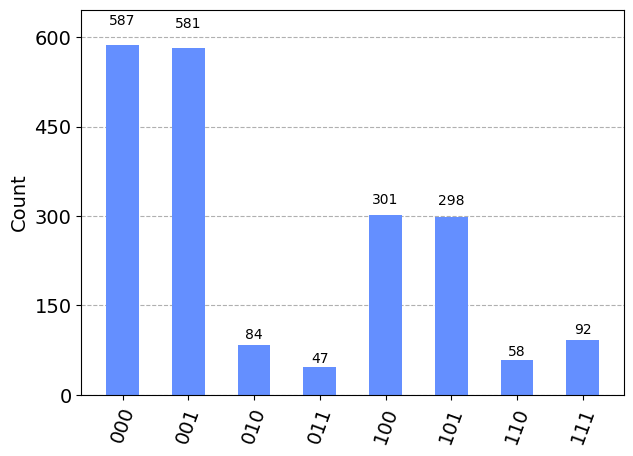

In [19]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

# The theta comes down to 2 values i.e. 0 or 1/8. Seems like it kind of gives us a range.

In [20]:
backend =  Aer.get_backend('unitary_simulator')
job = execute(qc, backend, shots=100)  # shots default = 1024
result = job.result()
U = result.get_unitary(qc, 3)
print(result.get_unitary(qc, 3))

Operator([[0.   -0.j   , 1.   +0.j   ],
          [0.707+0.707j, 0.   -0.j   ]],
         input_dims=(2,), output_dims=(2,))


In [21]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
state_vector = result.get_statevector()

# Print the statevector
print(state_vector)

Statevector([2.34326020e-17-5.65713056e-17j,
             7.07106781e-01+7.07106781e-01j],
            dims=(2,))


In [16]:
print(result.get_counts())

{'1': 1.0}


# This experiment indicates that there can be some error in phase estimation. It is not exact result. Thus the amount of error from one iteration of phase estimation depends on the precesion. If precision is p, that is 1/8 in above example, the error can vary from -p to +p. Thus result can be in range of 2p.